# Supervised Shallow Machine Learning: Random Forest Classifier

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; padding: 10px; margin: 10px 0; text-align: center;">
    
    Random forest classifier is an *ensemble* learning method that builds multiple decision trees and aggregates 
    their discrete class votes to capture complex nonlinear relationships in data.
</div>

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# For Data Wrangling:
import numpy as np
import pandas as pd
import xarray as xr

# ML Modeling:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# For Data Plotting:
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Useful to have:
from progressbar import progressbar

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Pre/processing
</div>

### Load txt file -- option to 'zero' using `rhos_2202` and add columns `NDVI`, `Slope`, `FDI`

### Load processed txt file using pandas' `read_csv function`

In [2]:
# Data are imported in Dataframe format
MSI_df = pd.read_csv('0_Barbados_Sargassum.txt', delimiter="\t")

# Duplicate FDI to give it more influence
MSI_df['FDI_0'] = MSI_df['FDI']

# Show new dataframe
print(MSI_df.head(2))

       Class      443      492      560      665      704      740      783  \
0  Sargassum  0.00472  0.00759  0.03235  0.03537  0.11956  0.17820  0.22438   
1  Sargassum  0.00364  0.00642  0.03314  0.03222  0.12599  0.18887  0.23300   

       833      865     1614  2202     SLOPE      FDI     NDVI    FDI_0  
0  0.23218  0.26549  0.00844   0.0  20.15865  0.39034  0.73563  0.39034  
1  0.25135  0.27627  0.01153   0.0  22.44026  0.41550  0.77275  0.41550  


In [3]:
# Define feature columns
features = ["704", "740", "783", "833", "NDVI", "SLOPE", "FDI", "FDI_0"]

X = MSI_df[features]
y = MSI_df["Class"]

# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(551, 8) (551,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [4]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 440
Testing set size: 111


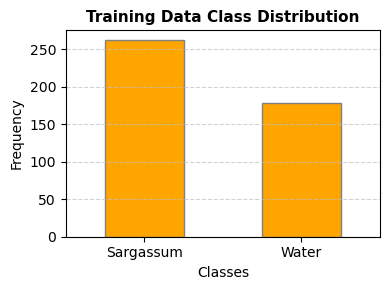

In [5]:
# Check distribution of classes in the training set
plt.figure(figsize = (4, 3))
ax = y_train.value_counts().plot(kind = 'bar', color = 'orange', edgecolor = 'grey')
# Formatting
ax.set_title("Training Data Class Distribution", fontsize = 11, fontweight = 'bold')
ax.set_xlabel("Classes", fontsize = 10)
ax.set_ylabel("Frequency",fontsize= 10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', color='silver', alpha=0.7)
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Random Forest Classifier
</div>

In [6]:
#Fit the model on training set
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

# Classify based on test data
y_pred = rf_model.predict(X_test)

### Save our new model

In [7]:
# Save newly trained GNB model to file
joblib.dump(rf_model, "RF_Classifier.pkl");

# Later, to load the model:
# clf = joblib.load("sargassum_classifier.pkl")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Metrics for RF classifier: `Accuracy`, `Precision`, `Recall`, `F1-score`

In [8]:
# Calcuate error/accuracy on y_test
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 1.00


### Confusion Matrix

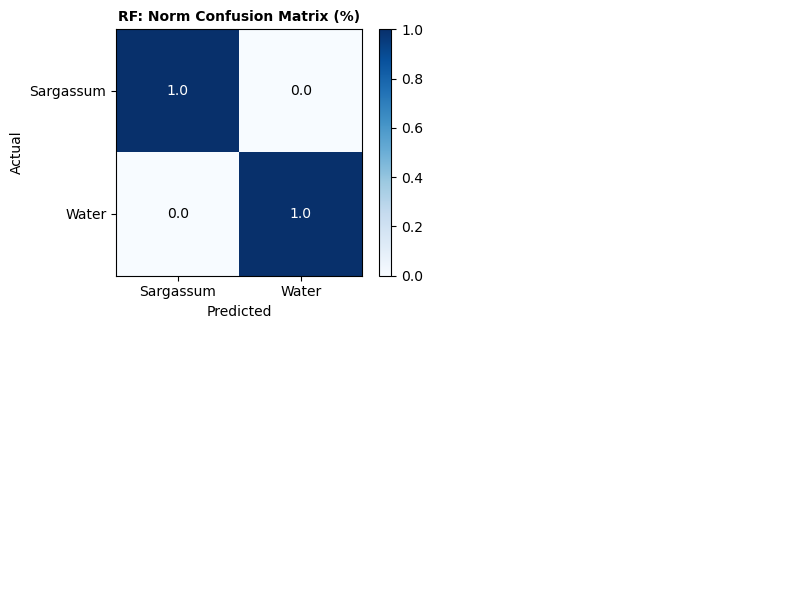

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 6))
# Plot the confusion matrix in the first subplot (position [0, 0])
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize = True, ax = axs[0, 0])
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("Actual")
axs[0, 0].set_title("RF: Norm Confusion Matrix (%)", fontsize = 10, weight = 'bold')

# Turn off the other subplots
axs[0, 1].axis("off")
axs[1, 0].axis("off")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Testing Model on New Data
</div>

### Functions we will need to call later:

In [10]:
#------------------------------------------------------------------------------------------#
def get_band_mapping(MSI_data):
    """
    Create a mapping from our internal feature names to the expected band names 
    in the MSI dataset. If the dataset uses S2B naming (i.e. missing 'rhos_443'),
    rename the bands to match the S2A convention.
    
    Returns:
        mapping (dict): Maps feature keys (e.g., "560") to band names (e.g., "rhos_560").
        MSI_data (xarray.Dataset): Updated dataset with renamed bands if necessary.
    """
    mapping = {
        "560"  : "rhos_560",
        "665"  : "rhos_665",
        "704"  : "rhos_704",
        "740"  : "rhos_740",
        "783"  : "rhos_783",
        "833"  : "rhos_833",
        "865"  : "rhos_865",
        "1614" : "rhos_1614",
        "2202" : "rhos_2202"
    }
    try:
        _ = MSI_data["rhos_443"]
    except KeyError:
        # Update band names to match S2A convention if S2B naming is detected.
        MSI_data = MSI_data.rename({
            "rhos_442" : "rhos_443",
            "rhos_559" : "rhos_560",
            "rhos_739" : "rhos_740",
            "rhos_780" : "rhos_783",
            "rhos_864" : "rhos_865",
            "rhos_1610": "rhos_1614",
            "rhos_2186": "rhos_2202"
        })
    return mapping, MSI_data
    
#------------------------------------------------------------------------------------------#
def compute_zeroed_features(MSI_data):
    """
    Apply a zeroing operation to the MSI bands by subtracting the reference band 
    (2202) and clipping negative values. Then compute additional indices such as 
    NDVI, FDI, and SLOPE.
    
    Returns:
        features (dict): Contains the zeroed bands and computed indices.
    """
    mapping, MSI_data = get_band_mapping(MSI_data)
    
    # Extract the band values using the mapping.
    band560  = MSI_data[mapping["560"]].values
    band665  = MSI_data[mapping["665"]].values
    band704  = MSI_data[mapping["704"]].values
    band740  = MSI_data[mapping["740"]].values
    band783  = MSI_data[mapping["783"]].values
    band833  = MSI_data[mapping["833"]].values
    band865  = MSI_data[mapping["865"]].values
    band1614 = MSI_data[mapping["1614"]].values
    band2202 = MSI_data[mapping["2202"]].values  # Reference band
    
    # Helper function to zero out negative values after subtracting the reference.
    def zero_and_clip(band, ref):
        result = band - ref
        result[result < 0] = 0
        return result
    
    # Apply zeroing to each band.
    band560  = zero_and_clip(band560, band2202)
    band665  = zero_and_clip(band665, band2202)
    band704  = zero_and_clip(band704, band2202)
    band740  = zero_and_clip(band740, band2202)
    band783  = zero_and_clip(band783, band2202)
    band833  = zero_and_clip(band833, band2202)
    band865  = zero_and_clip(band865, band2202)
    band1614 = zero_and_clip(band1614, band2202)
    
    # Compute NDVI using safe division to avoid division by zero.
    denom = band833 + band665
    NDVI  = np.divide(band833 - band665, denom, out=np.zeros_like(denom), where=denom != 0)
    
    # Compute FDI (Floating Debris Index) and duplicate it as FDI_0.
    FDI   = band833 - (band704 + (band1614 - band740) * 1.636)
    FDI_0 = FDI
    
    # Compute SLOPE index.
    SLOPE = (band833 - band704) * 179

    return {
        "560"  : band560,
        "665"  : band665,
        "704"  : band704,
        "740"  : band740,
        "783"  : band783,
        "833"  : band833,
        "865"  : band865,
        "1614" : band1614,
        "NDVI" : NDVI,
        "SLOPE": SLOPE,
        "FDI_0": FDI_0,
        "FDI"  : FDI}

#------------------------------------------------------------------------------------------#
def get_class(MSI_data):
    """
    Build the feature matrix from MSI_data using zeroed features, then predict 
    the class for each pixel using the trained classifier. Finally, reshape the 
    predicted class array back into the original image dimensions.
    
    Returns:
        predictions (np.ndarray): 2D array of predicted classes.
    """
    features = compute_zeroed_features(MSI_data)
    
    # Define feature order as per training.
    feature_order = ["704", "740", "783", "833", "NDVI", "SLOPE", "FDI", "FDI_0"]
    sample_shape = features[feature_order[0]].shape
    
    # Flatten each feature to form a 2D feature matrix (one row per pixel).
    feature_matrix = np.column_stack([features[f].flatten() for f in feature_order])
    
    # Use the trained classifier (model must be loaded) to predict classes.
    predictions = model.predict(feature_matrix)
    
    # Reshape predictions to match the spatial grid of the original image.
    predictions = predictions.reshape(sample_shape)
    return predictions
    
#------------------------------------------------------------------------------------------#

### Load new dataset with `xarray` and trained model with `joblib`

In [11]:
# Load data
MSI_data = xr.open_dataset("subset__S2B_MSI_20180426_PUR_L2R_Barbados.nc") 

# Load model
model = joblib.load("RF_Classifier.pkl")

### Classification: run model on new (unseen) data

In [12]:
# Run classifier model on new data
# Parallel process; shows progress
for i in progressbar(range(100)): 
    out_class = get_class(MSI_data)

100% (100 of 100) |######################| Elapsed Time: 0:01:21 Time:  0:01:210007


### Plotting predicated classes

In [13]:
# Convert string labels to numeric codes:
label_uni = np.unique(out_class)
label_int = {label: i for i, label in enumerate(label_uni)}

# Create a numeric version of out_class
out_class_num = np.vectorize(label_int.get)(out_class)

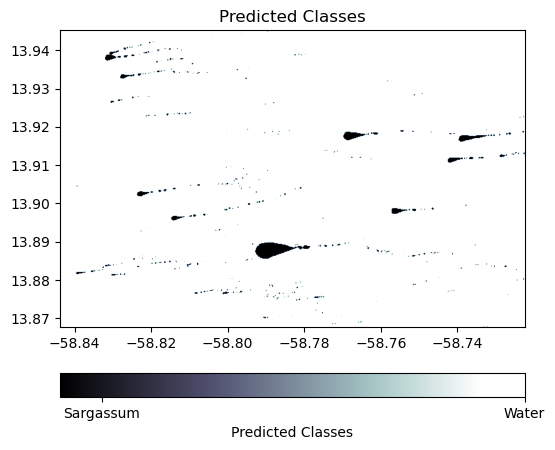

In [14]:
# Extract latitude and longitude arrays from MSI_data
lat2d = MSI_data['lat'].values  # 2D array, shape (616, 949)
lon2d = MSI_data['lon'].values  # 2D array

# Compute the extent boundaries
lon_min, lon_max = np.nanmin(lon2d), np.nanmax(lon2d)
lat_min, lat_max = np.nanmin(lat2d), np.nanmax(lat2d)

# Now plot the numeric array:
plt.figure(figsize = (6, 6))
plt.imshow(out_class_num, cmap='bone', origin='upper',
           extent=[lon_min, lon_max, lat_min, lat_max])
cbar = plt.colorbar(orientation= 'horizontal', fraction = 0.1, pad = 0.1)

# Set colorbar ticks centered on each class. Use the integer codes.
num_classes = len(label_uni)
ticks = np.arange(0.1, num_classes, 1)
cbar.set_ticks(ticks)

# Optionally label ticks with the class names
cbar.set_ticklabels([str(label) for label in label_uni])
cbar.set_label('Predicted Classes', fontsize = 10)
plt.title("Predicted Classes")

plt.show()